## 참고 소스코드 및 문헌
### Hugging Face BERT Chris McCormick의 오픈소스 
https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=PGnlRWvkY-2c

### 네이버 영화리뷰 감정분석 with Hugging Face BERT
https://colab.research.google.com/drive/1Xs99-e4g6KS5Alu7z9CnrWX0J_f5HBsQ#scrollTo=muU2kS2GCh4y

### Hugging Face Transformers 공식 library
https://huggingface.co/transformers/_modules/transformers/models/electra/modeling_electra.html#ElectraModel 참고

In [7]:
# 구글 드라이브의 디렉토리와 Colab을 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!ls drive/MyDrive/Friends

friends_dev.json  friends_test.json  friends_train.json


In [2]:
!pip install transformers

     |████████████████████████████████| 1.5MB 14.2MB/s 
     |████████████████████████████████| 890kB 47.8MB/s 
     |████████████████████████████████| 2.9MB 47.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=67d585fc7cbdf30e84c8c4659cf55f058c45df511c087120642afcebe2c9fbd5
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
import tensorflow as tf
import torch
import json
import re
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification, RobertaConfig, AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

import pandas as pd
import numpy as np
import random
import time
import datetime

#### nltk에서 불용어 리스트를 적어두었지만, 감성분석에서 부정형 단어 not, don't의 경우 중요한 의미를 지니는 것으로 판단 => nltk 불용어 리스트 일부 수정
- 살리는 단어 : not, no, nor
- 추가한 단어 : 2개 char이하 문자 등

In [4]:
# 단어 변경 함수
def change_word(sen):
  replace_tup = [('aren\'t', 'are not'),
                  ('couldn\'t', 'could not'),
                  ('didn\'t', 'did not'),
                  ('doesn\'t', 'does not'),
                  ('don\'t', 'do not'),
                  ('hadn\'t', 'had not'),
                  ('hasn\'t', 'has not'),
                  ('haven\'t', 'have not'),
                  ('isn\'t', 'is not'),
                  ('mightn\'t', 'might not'),
                  ('mustn\'t', 'must not'),
                  ('needn\'t', 'need not'),
                  ('shan\'t', 'shall not'),
                  ('shouldn\'t', 'should not'),
                  ('wasn\'t', 'was not'),
                  ('weren\'t', 'were not'),
                  ('won\'t', 'will not')
                 ]

  for a,b in replace_tup : 
    if a in sen :
     sen = re.sub(a,b,sen)
  return sen

In [5]:
# 불용어 리스트 - 대화의미를 가지는 단어는 남김, 극중 이름은 감성에 영향주지 않을것이라 판단 제거
stop_lst=['Kate','Lauren','kate','lauren','Rachel','Ross','Phoebe',"Chandler","Joey","Monica",'rachel','ross','phoebe',"chandler","joey","monica",'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you','even', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'd', 'll', 'm', 'o', 're', 've', 'y', "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p",
          "q", "r", "s", "t", "u", "v", "w", "x", "y", "z","A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z",'co','op','0o', '0s', '3a', '3b', '3d', '6b', '6o', 'a1', 'a2', 'a3', 'a4', 'ab', 'ac', 'ad', 'ae', 'af', 'ag', 'aj', 'al', 'an', 'ao', 'ap', 'ar', 'av', 'aw', 'ax', 'ay', 'az', 'b1', 'b2', 'b3', 'ba', 'bc', 'bd', 'be', 'bi', 'bj', 'bk', 'bl', 'bn', 'bp', 'br', 'bs', 'bt', 'bu', 'bx', 'c1', 'c2', 'c3', 'cc', 'cd', 'ce', 'cf', 'cg', 'ch', 'ci', 'cj', 'cl', 'cm', 'cn', 'cp', 'cq', 'cr', 'cs', 'ct', 'cu', 'cv', 'cx', 'cy', 'cz', 'd2', 'da', 'dc', 'dd', 'de', 'df', 'di', 'dj', 'dk', 'dl', 'do', 'dp', 'dr', 'ds', 'dt', 'du', 'dx', 'dy', 'e2', 'e3', 'ea', 'ec', 'ed', 'ee', 'ef', 'ei', 'ej', 'el', 'em', 'en', 'eo', 'ep', 'eq', 'er', 'es', 'et', 'eu', 'ev', 'ex', 'ey', 'f2', 'fa', 'fc', 'ff', 'fi', 'fj', 'fl', 'fn', 'fo', 'fr', 'fs', 'ft', 'fu', 'fy', 'ga', 'ge', 'gi', 'gj', 'gl', 'go', 'gr', 'gs', 'gy', 'h2', 'h3', 'hh','hj', 'ho', 'hr', 'hs', 'hu', 'hy', 'i', 'i2', 'i3', 'i4', 'i6', 'i7', 'i8', 'ia', 'ib', 'ic', 'ie', 'ig', 'ih', 'ii', 'ij', 'il', 'in', 'io', 'ip', 'iq', 'ir', 'iv', 'ix', 'iy', 'iz', 'jj', 'jr', 'js', 'jt', 'ju', 'ke', 'kg', 'kj', 'km', 'ko', 'kl','gr','l2', 'la', 'lb', 'lc', 'lf', 'lj', 'ln', 'lo', 'lr', 'ls', 'lt', 'm2', 'ml', 'mn', 'mo', 'ms', 'mt', 'mu', 'n2', 'nc', 'nd', 'ne', 'ng', 'ni', 'nj', 'nl', 'nn', 'nr', 'ns', 'nt', 'ny', 'oa', 'ob', 'oc', 'od', 'of', 'og', 'oi', 'oj', 'ol', 'om', 'on', 'oo', 'oq', 'or', 'os', 'ot', 'ou', 'ow', 'ox', 'oz', 'p1', 'p2', 'p3', 'pc', 'pd', 'pe', 'pf', 'ph', 'pi', 'pj', 'pk', 'pl', 'pm', 'pn', 'po', 'pq', 'pr', 'ps', 'pt', 'pu', 'py', 'qj', 'qu', 'r2', 'ra', 'rc', 'rd', 'rf', 'rh', 'ri', 'rj', 'rl', 'rm', 'rn', 'ro', 'rq', 'rr', 'rs', 'rt', 'ru', 'rv', 'ry', 's2', 'sa', 'sc', 'sd', 'se', 'sf', 'si', 'sj', 'sl', 'sm', 'sn', 'sp', 'sq', 'sr', 'ss', 'st', 'sy', 'sz', 't1', 't2', 't3', 'tb', 'tc', 'td', 'te', 'tf', 'th', 'ti', 'tj', 'tl', 'tm', 'tn', 'tp', 'tq', 'tr', 'ts', 'tt', 'tv', 'tx', 'ue', 'ui', 'uj', 'uk', 'um', 'un', 'uo', 'ur', 'ut', 'va', 'wa', 'vd', 'wi', 'vj', 'vo', 'wo', 'vq', 'vt', 'vu', 'x1', 'x2', 'x3', 'xf', 'xi', 'xj', 'xk', 'xl', 'xn', 'xo', 'xs', 'xt', 'xv', 'xx', 'y2', 'yj', 'yl', 'yr', 'ys', 'yt', 'zi', 'zz']

In [9]:
with open('drive/MyDrive/Friends/friends_train.json') as json_file:
    json_train = json.load(json_file)
with open('drive/MyDrive/Friends/friends_test.json') as json_file:
    json_test = json.load(json_file)
with open('drive/MyDrive/Friends/friends_dev.json') as json_file:
    json_dev = json.load(json_file)

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def preprocess(str):
    replaceAll = str
    replaceAll = re.sub('\u0092','\'',replaceAll) # 어퍼트로스피 살리기
    replaceAll = change_word(replaceAll) # 부정형 단어 바꾸기
    only_english = re.sub('[^a-zA-Z?!]', ' ', replaceAll) # 영어문자와 느낌표 물음표 남기기 => 시트콤에서 물음표, 느낌표는 감성에서 중요할 것으로 판단
    only_english = re.sub('\?', ' ?', only_english)
    only_english = re.sub('\!', ' !', only_english)
    no_capitals = only_english.lower().split()
    no_stops = [word for word in no_capitals if not word in stop_lst] # 불용어 제거
    lemma_words = [lemmatizer.lemmatize(word) for word in no_stops] # 어근의 의미를 파악할 수 있는 lemma진행(stemming대신)
    return ' '.join(lemma_words)

train_data=[]
val_data=[]
test_data=[]

for rows in json_train:
    for row in rows:
        train_data.append([preprocess(row['utterance']), row['emotion']])
for rows in json_dev:
    for row in rows:
        val_data.append([preprocess(row['utterance']), row['emotion']])
for rows in json_test:
    for row in rows:
        test_data.append([preprocess(row['utterance']), row['emotion']])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [10]:
# 훈련셋 / 테스트셋 로드
train_data = pd.DataFrame(train_data, columns=['document','emotion'])
val_data = pd.DataFrame(val_data, columns=['document','emotion'])
test_data = pd.DataFrame(test_data, columns=['document','emotion'])

In [11]:
def label_ch(str):
  return {'non-neutral': 0,
            'neutral': 1, 
            'joy': 2,
            'sadness': 3,
            'fear': 4,
            'anger': 5,
            'surprise': 6,
            'disgust': 7}[str]

def convert_emotion(data) :
  label_lst = [label_ch(i) for i in data['emotion']]
  label_pd = pd.DataFrame(label_lst,columns=['label'])
  data = pd.concat([data, label_pd],axis=1)
  return data

In [12]:
train_data = convert_emotion(train_data)
val_data = convert_emotion(val_data)
test_data = convert_emotion(test_data)

In [13]:
# 150,000 훈련셋 / 50,000 테스트셋
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(10561, 3)
(1178, 3)
(2764, 3)


In [14]:
# 문장, label 추출
sen_train = train_data['document']
labels_train = train_data['label'].values

sen_val = val_data['document']
labels_val = val_data['label'].values

sen_test = test_data['document']
labels_test = test_data['label'].values

### Electra baseline 모델 구축

In [15]:
# BERT input 형식으로 변환
# Freinds 문장이 하나인 것이 대부분
sen_bert_train = []
for i in sen_train:
  x = "<s> " + str(i) + "</s>"
  sen_bert_train.append(x)

sen_bert_val = []
for i in sen_val:
  x = "<s> " + str(i) + "</s>"
  sen_bert_val.append(x)

sen_bert_test = []
for i in sen_test:
  x = "<s> " + str(i) + "</s>"
  sen_bert_test.append(x)

In [16]:
# Electra 토크나이저로 문장 토큰 분리
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False) # roberta의 경우 sentencepiece tokenizer 사용
tokenized_texts_train = [tokenizer.tokenize(sent) for sent in sen_bert_train]
tokenized_texts_val = [tokenizer.tokenize(sent) for sent in sen_bert_val]
tokenized_texts_test = [tokenizer.tokenize(sent) for sent in sen_bert_test]

In [17]:
tokenizer.tokenize(sen_bert_train[14])

['<s>',
 'Ġbut',
 'Ġthen',
 'Ġ?',
 'Ġthe',
 'Ġwaitress',
 'Ġwent',
 'Ġout',
 'Ġwith',
 'Ġlast',
 'Ġmonth',
 'Ġ?',
 '</s>']

In [18]:
print(tokenizer.all_special_ids)
print(tokenizer.all_special_tokens)

[0, 2, 3, 2, 1, 0, 50264]
['<s>', '</s>', '<unk>', '</s>', '<pad>', '<s>', '<mask>']


In [19]:
# vocab size : 50265
tokenizer.vocab_size

50265

In [20]:
# 입력 토큰의 최대 시퀀스 길이 찾기
sen_len = [len(sen) for sen in sen_bert_val]
max(sen_len)

156

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

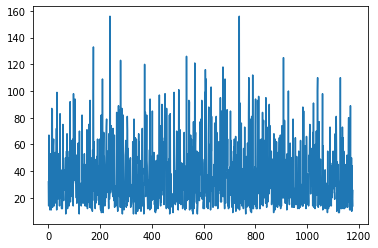

In [22]:
plt.plot(sen_len)

In [23]:
# 토큰의 최대 시퀀스 길이
MAX_LEN = 128 # 대부분 128 미만

# 토큰을 숫자 인덱스로 변환
input_ids_train = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_train]
input_ids_val = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_val]
input_ids_test = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test]
# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids_train = pad_sequences(input_ids_train, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post", value=1.0) #roberta padding은 1
input_ids_val = pad_sequences(input_ids_val, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post", value=1.0)
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post", value=1.0)

In [ ]:
# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_texts_train[0])

# Display the words with their indeces.
for i in range(10):
  for tup in zip(tokenized_texts_train[i], input_ids_train[i]):
    print((tup[0], tup[1]))

In [25]:
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상

# 어텐션 마스크 초기화
attention_masks_train = []
attention_masks_val = []
attention_masks_test = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
for seq in input_ids_train:
    seq_mask = [float(i!=1) for i in seq]
    attention_masks_train.append(seq_mask)

for seq in input_ids_val:
    seq_mask = [float(i!=1) for i in seq]
    attention_masks_val.append(seq_mask)

for seq in input_ids_test:
    seq_mask = [float(i!=1) for i in seq]
    attention_masks_test.append(seq_mask)

In [26]:
# 파이토치의 텐서로 변환
# train, validaiton set
train_inputs = torch.tensor(input_ids_train)
train_labels = torch.tensor(labels_train)
train_masks = torch.tensor(attention_masks_train)
validation_inputs = torch.tensor(input_ids_val)
validation_labels = torch.tensor(labels_val)
validation_masks = torch.tensor(attention_masks_val)

# test set
test_inputs = torch.tensor(input_ids_test)
test_labels = torch.tensor(labels_test)
test_masks = torch.tensor(attention_masks_test)

In [27]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_tensor = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_tensor)
train_dataloader = DataLoader(train_tensor, sampler=train_sampler, batch_size=batch_size)

validation_tensor = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_tensor)
validation_dataloader = DataLoader(validation_tensor, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

### 모델생성

In [28]:
# GPU 사용 확인
!nvidia-smi

Sat Dec 19 09:25:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     7W /  75W |     10MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla P4


In [ ]:
# 분류 BERT 모델 생성
config = RobertaConfig.from_pretrained('roberta-base',
                                    hidden_dropout_prob=0.1,
                                    attention_probs_dropout_prob=0.1,
                                    num_labels=8
                                    )
model = RobertaForSequenceClassification.from_pretrained('roberta-base', config=config)
model.cuda() # gpu 사용

In [32]:
# model.config

In [33]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 6

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)
# 손실함수 설정; softmax와 cross-entropy를 합쳐놓은 것
# weights = torch.tensor(class_weights).to(device, dtype= torch.float32)
loss_fn = torch.nn.CrossEntropyLoss().to(device)

In [34]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten() #argmax는 index출력
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# 그래디언트 초기화
model.zero_grad()

pre_avg_val_loss = 1

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0
    val_total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴 - 배치사이즈가 클 경우 out of memory 문제
    for step, batch in enumerate(train_dataloader):
        # 단순 경과 정보 표시, 실제 BERT학습은 32 batch size씩
        if step % 100 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Step {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
        
        loss = loss_fn(outputs.logits, b_labels) # logits; loss_fn이 softmax 자동수행

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    val_loss, eval_accuracy,eval_f1 = 0, 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
            
        # val loss 계산
        val_loss = loss_fn(outputs.logits, b_labels)
        val_total_loss += val_loss.item()

        # 로짓 구함; 최종 신경망 레이아웃
        logits = outputs.logits

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

        # f1-score 계산
        tmp_eval_f1 = f1_score(label_ids, np.argmax(logits, axis=1).flatten(), average = 'weighted')
        eval_f1 += tmp_eval_f1


    # 평균 로스 계산
    avg_val_loss = val_total_loss / len(validation_dataloader)

    print("  Average validation loss: {0:.4f}".format(avg_val_loss))
    print("  Accuracy: {0:.4f}".format(eval_accuracy / nb_eval_steps))
    print("  f1-score: {0:.4f}".format(eval_f1 / nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

    if avg_val_loss < pre_avg_val_loss:
        torch.save(model.state_dict(), 'drive/MyDrive/Friends_roberta_state_dict_v4_best.pt')
        print(" validation loss update")

    pre_avg_val_loss = avg_val_loss

print("")
print("Training complete!")

In [ ]:
model.load_state_dict(torch.load('drive/MyDrive/Friends_roberta_state_dict_v4_best.pt'))  # state_dict를 불러 온 후, 모델에 저장

### 테스트셋 평가

In [ ]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Step {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
        # 로짓 구함
    logits = outputs.logits

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.4f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))